# Table of Contents

1. Import Libraries
2. Load Dataset
3. Preprocessing and Exploring Text Data
  
  3.1 Text Cleaning
  
  3.2 Finding Word Count

  3.3 Find and Replace Rare Words with "Unknown" Token

4. Data Preparation

  4.1 Prepare Sequences

  4.2 Create Token-Integer Mappings

  4.3 Split Data into Train and Validation Sets

  4.4 Pad Sequences

  4.5 Convert Text Sequences to Integer Sequences</br>
  4.6 Implement GloVe Embeddings
5. Model Building

  5.1 Define Model Architecture
  
  5.2 Start Model Training
6. Text Generation
7. Test Model

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F

import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras import backend as K 
K.clear_session()

In [56]:
# reproducing same results
SEED = 2019

np.random.rand(SEED)

array([0.81417449, 0.70178533, 0.52274066, ..., 0.67327162, 0.0728112 ,
       0.51491242])

# 2. Load Dataset

In [57]:
# open text file and read in data
with open("Dailog-dataset.dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

In [58]:
# number of text sequences
len(dialogs)

64776

In [59]:
# print 10 random dialogs
random.sample(dialogs, 10)

['Thank you, goodbye',
 "That's a little early but that will be fine, did they have a booth available?",
 'Well I need to be picked up at my house',
 'The one in Chicago on Harlem Ave',
 'Mid range price and something unique, not too fancy, but a sit down place ',
 'OK, well who knows if the weather forecast will hold up, inside is fine',
 'I am at the Inland Plaza in San Bernadino, and I want to go to the Riverside Plaza',
 'No I think that is it',
 'Reach out to Intelligent Auto Solutions and tell them I need to come in now',
 "I'll be attending the movie with a friend, so we'd like two tickets"]

# 3. Preprocessing and Exploring Text Data

## 3.1 Text Cleaning

In [60]:
# text cleaning
dialogs_clean = []

for i in dialogs:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i)
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  dialogs_clean.append(i)


## 3.2 Finding Word Count

In [61]:
# get list of all the words
all_words = " ".join(dialogs_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:   
  # check if the word is already in dictionary 
  if word in words_dict:
    # increment count of word by 1 
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1 
    words_dict[word] = 1

In [62]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [63]:
# vocabulary size
len(words_df)

11147

In [64]:
words_df.head()

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1
3,andrea,1
4,precice,1


In [65]:
words_df.tail()

,word,count
11142,you,11909
11143,a,13380
11144,to,14000
11145,the,15406
11146,i,19654


## 3.3 Find and Replace Rare Words with "Unknown" Token

In [66]:
# user specified threshold value
rare_thresh = 2

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [67]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 47.98
Rare words coverage in the corpus: 1.12


In [68]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

Replace the rare words/tokens in the dataset with a special token known as the unknown token ("\<unk\>")

In [69]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i)

print(pattern)

day|book|


In [70]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [71]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [72]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list 
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
#for d in tqdm_notebook(dialogs_clean):
for d in dialogs_clean:
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

In [73]:
dialogs_clean_v2 = dialogs_clean_v2[:20000]

In [74]:
dialogs_clean_v2[:10]

["hi i'm looking to book a table for korean fod",
 'somewhere in southern nyc maybe the east village',
 " we don't want to sit at the bar but anywhere else is fine",
 'what times are available',
 "yikes we can't do those times",
 'let me check',
 "great let's book that",
 "no that's it just book",
 'hi i would like to see if the movie what men want is playing here',
 'yes for me and a friend so two tickets please']

# 4. Data Preparation

## 4.1 Prepare Sequences

20000


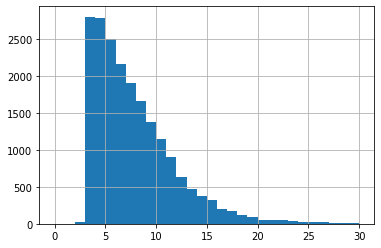

In [75]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))
print(len(text_word_count))

In [76]:
# function to create sequences of equal length
def create_seq1(text, seq_len = 5):
      
  sequences = []    
  temp = 0
  seq_len1 = 5
  if len(text.split()) > seq_len:
    for i in range(0, round(len(text.split())/seq_len)):
      # select sequence of tokens
      seq = text.split()[temp:seq_len1]
      temp = seq_len1
      seq_len1 = seq_len + temp
      
      if len(seq) > 0:
        # append sequence to the list
        sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [77]:
# function to create sequences of equal length
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [78]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2 if len(i) < 100 and len(i) > 1]
#seqs = [i for i in dialogs_clean_v2 if len(i) < 80]
seqs[:10]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"],
 ["no that's it just book"],
 ['hi i would like to see',
  'i would like to see if',
  'would like to see if the',
  'like to see if the movie',
  'to see if the movie what',
  'see if the movie what men',
  'if the movie what men want',
  'the movie what men want is',
  'movie what men want is playing',
  'what men want is playing here'],
 ['yes for m

In [79]:
# merge list-of-lists into a single list
corpus = sum(seqs, [])


In [55]:
corpus[:20]

[]

 **4.2 Create Token-Integer Mappings**

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [28]:
total_words

4848

**4.3 Generates a list of n-gram sequences and list of n-gram sequences**

In [29]:
#Create n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    output_sequences = []
    ### START CODE HERE
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      
      for i in range(1, len(token_list)):
        n_gram_seqs= token_list[:i]
        #print(n_gram_seqs)
        input_sequences.append(n_gram_seqs)
        output_sequences.append(token_list[i:i+1])
        
    ### END CODE HERE
    
    return input_sequences, output_sequences

In [30]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences, output_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences length: {len(input_sequences)}")
print(f"maximum length of sequences : {max_sequence_len}")
input_sequences[:10]

n_grams of input_sequences length: 277183
maximum length of sequences : 5


[[121],
 [121, 59],
 [121, 59, 139],
 [121, 59, 139, 1],
 [121, 59, 139, 1, 55],
 [59],
 [59, 139],
 [59, 139, 1],
 [59, 139, 1, 55],
 [59, 139, 1, 55, 3]]

In [31]:
output_sequences[:10]

[[59], [139], [1], [55], [3], [139], [1], [55], [3], [110]]

**4.4 Create Token-Integer Mappings**

In [32]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to same length
    
    Args:
        input_sequences: tokenized sequences to pad
        maxlen: maximum length of sequences
    
    Returns:
        padded_sequences: tokenized sequences padded to  same length
    """

    post_pad_sequence = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')
    return post_pad_sequence

In [33]:
# Pad the whole corpus
pad_sequence = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {pad_sequence.shape}")

padded corpus has shape: (277183, 5)


In [34]:
pad_sequence

array([[  0,   0,   0,   0, 121],
       [  0,   0,   0, 121,  59],
       [  0,   0, 121,  59, 139],
       ...,
       [  0,   0,  84,  14,   4],
       [  0,  84,  14,   4, 200],
       [ 84,  14,   4, 200,   9]], dtype=int32)

In [35]:
def features_and_labels(pad_sequence, labels, total_words):

    #features = pre_pad_sequence[:,:-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return pad_sequence, one_hot_labels

In [36]:
# Split the whole corpus
features, labels = features_and_labels(pad_sequence, output_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")


features have shape: (277183, 5)
labels have shape: (277183, 4848)


In [53]:
post_pad_sequence = []
pre_pad_sequence = []
seqs = []
#corpus = []
features

array([[  0,   0,   0,   0, 121],
       [  0,   0,   0, 121,  59],
       [  0,   0, 121,  59, 139],
       ...,
       [  0,   0,  84,  14,   4],
       [  0,  84,  14,   4, 200],
       [ 84,  14,   4, 200,   9]], dtype=int32)

# **Implement Glove to get better accuracy**

In [38]:
# Define path to file containing the embeddings
GLOVE_FILE = './glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, 'r', errors = 'ignore', encoding='utf8') as f:
    for line in f:
        values = line.split()
        values = ['0' if x=='.' else x for x in values]
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

f.close()

In [39]:
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
# Initialize empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((total_words+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# **5.1 Define Model Architecture**

In [40]:
from keras import regularizers
from keras.regularizers import l2
def create_model(total_words, embedding_dim, embeddings_matrix,  max_sequence_len):
  model = Sequential()
  #model.add(Embedding(total_words, 100, input_length=max_sequence_len))

  model.add(Embedding(total_words+1, embedding_dim, input_length=max_sequence_len, weights=[embeddings_matrix]))
  #model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.15 , dropout = 0.15))
  #model.add(tf.keras.layers.Dropout(.2))
  model.add(Bidirectional(LSTM(units=128)))

  model.add(Dense(total_words, activation='softmax'))
  learning_rate = 0.001
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer= opt,
                metrics=['accuracy'])

  model.summary()
  return model

 **5.2 Train Model**

In [41]:
# Get the untrained model
epochs=50
model = create_model(total_words, EMBEDDING_DIM, EMBEDDINGS_MATRIX, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=65, verbose=2, batch_size = 512)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 100)            484900    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4848)              1245936   
                                                                 
Total params: 1,965,332
Trainable params: 1,965,332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/65
542/542 - 10s - loss: 5.1752 - accuracy: 0.1364 - 10s/epoch - 19ms/step
Epoch 2/65
542/542 - 7s - loss: 4.0863 - accuracy: 0.2424 - 7s/epoch - 13ms/step
Epoch 3/65
542/542 - 7s - loss: 3.6562 - accuracy: 0.2840 - 7s/epoch - 14ms/step

# **6 Accuracy and Loss curves of trainned model**

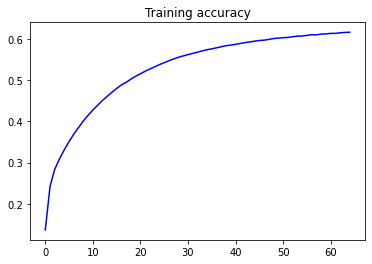

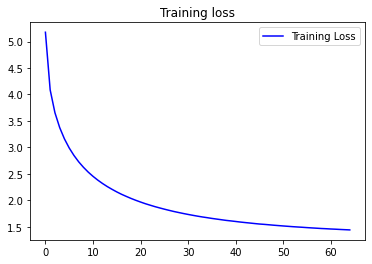

In [42]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

**Final Results**: Getting 0.6585 accuracy with GLOVE EMBEDDINGS and predicting perfectly on random datasets.

# **Download model**

In [43]:
#download model
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('NextWord_Generation_EDA.pkl')

#download_history()

# **Test model with new sentence**

In [50]:

def pred(seed_text): 
	next_words = 3		
	for _ in range(next_words):
		# Convert the text into sequences
		token_list = tokenizer.texts_to_sequences([seed_text])[0]
		# Pad the sequences
		token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
		# Get the probabilities of predicting a word
		predicted = model.predict(token_list, verbose=0)
		# Choose the next word based on the maximum probability
		predicted = np.argmax(predicted, axis=-1).item()
		# Get the actual word from the word index
		output_word = tokenizer.index_word[predicted]
		# Append to the current text
		seed_text += " " + output_word

	return seed_text


In [87]:
seeds = ["let's watch ", 'watch how to ', 'so neither', 'neither choices']
seeds_out = {} 
# number of tokens to generate
num_toks = 3

# text generation
for i,s in enumerate(seeds):
    seeds_out[i] = pred(seeds[i])
    

print(seeds_out)

{0: "let's watch  how to train", 1: 'watch how to  train your dragon', 2: 'so neither choices are playing', 3: 'neither choices are playing at'}


# **Sample Test Data**

In [81]:
corpus[60:65]

["let's watch how to train your",
 'watch how to train your dragon',
 'yes that one',
 'so neither choices are playing at',
 'neither choices are playing at the']